In [14]:
# Common standard libraries

import datetime
import time
import os

In [15]:
# Common external libraries

import pandas as pd
import numpy as np
import sklearn # scikit-learn
import requests
from bs4 import BeautifulSoup
from time import sleep
import datetime

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)


In [16]:
# Visualization libraries

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


In [17]:
# Setting plot appearance
# See here for more options: https://matplotlib.org/users/customizing.html

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['axes.labelpad'] = 10
sns.set_style("whitegrid")
# sns.set_context("poster", font_scale=1.0)


In [18]:
# Ignore warnings (don't display stderr)

import warnings
warnings.filterwarnings('ignore')

In [19]:
# if local use, then check presence of local data file (default = 0)

LOCAL = 1 # check for local data file and use it if it exists
#LOCAL = 0 # don't check for local data file, but download from Zenodo


# Circular Health Project
## Mortality Rate Analysis in Italy (2015-2020)

This notebook uses the mortality rates data file from a subset of municipalities in the ANPR system</br>
and the municipality census information to produce a set of customizable plots

Version: 1.0-20200504

In [20]:
# if local is specified, then try to use a local file if it exists, else call the generator to produce a fresh dataset
import os.path

if LOCAL:
    if not os.path.isfile('mortalita_giornaliero_comune_20200504.xlsx'):
        %run ./Italy_mortality_rates_dataset_generator_20200504.ipynb
else:
    %run ./Italy_mortality_rates_dataset_generator_20200504.ipynb
    
print('Loading aggregated data file...')
df_2020 = pd.read_excel(io='mortalita_giornaliero_comune_20200504.xlsx');
df_2020 = df_2020.drop(labels='Unnamed: 0', axis=1);
print('Loaded %d records' %len(df_2020))


Loading aggregated data file...
Loaded 666643 records


In [21]:
# helper functions

# add a date column with properly formatted date values based on GE
def setDate(data=None, year='1970'):
    if data is None:
        print("Missing dataset info")
        return
    
    newdata = pd.DataFrame(data)
    newdata['DATE'] = newdata['GE']
    newdata = newdata.astype({'DATE': str})
    newdata['DATE'] = newdata['DATE'].apply(lambda x: year + '-0'+ str(x)[0] + '-' + str(x)[1:3])
    
    # remove leap year date if not leap year
    if year != '2020':
        newdata = newdata[newdata.GE != 229]
        
    newdata['DATE'] = pd.to_datetime(newdata['DATE'], format='%Y-%m-%d') 
    
    return newdata

# add a column with running daily totals for the specified feature
def totalDaily(data=None, col=None, new_col='RUNNING_TOTAL'):

    global total
    total = 0

    def updateTotal(val):
        global total
        total = total + val
        return total
    
    if data is None or col is None:
        print("Missing input paramters")
        return
    
    newdata = pd.DataFrame(data)

    newdata = newdata.drop([new_col], axis=1, errors='ignore')
        
    newdata[new_col] = newdata[col].apply(lambda x: updateTotal(x))
    
    return newdata

# add a column with the mean running daily totals for the specified features
def totalMeanDaily(data=None, cols=None, new_col='RUNNING_TOTAL'):

    global total
    total = 0

    def updateTotal(row):
        global total
        mean_val = row[cols].mean()
        total = total + mean_val
        row[new_col] = total
        return row
    
    if data is None or cols is None:
        print("Missing input paramters")
        return
    
    newdata = pd.DataFrame(data)

    newdata = newdata.drop([new_col], axis=1, errors='ignore')
        
    newdata = newdata.apply(lambda x: updateTotal(x), axis=1)
    
    return newdata

In [22]:
# Mortality in total since 2020-01-01
cols_2020 = ['T_15','T_16','T_17','T_18','T_19','T_20']

mr_italy = pd.DataFrame(data=df_2020[cols_2020].sum()).T
print(mr_italy)

     T_15    T_16    T_17    T_18    T_19    T_20
0  179122  160708  179289  173279  174697  198794


In [23]:
# Mortality in per region since 2020-01-01
cols_2020 = ['T_15','T_16','T_17','T_18','T_19','T_20']

mr_regional = pd.DataFrame(data=df_2020.groupby('NOME_REGIONE')[cols_2020].sum())
print(mr_regional.sort_values('T_20', ascending=False))

                               T_15   T_16   T_17   T_18   T_19   T_20
NOME_REGIONE                                                          
Lombardia                     31285  27943  31381  30804  31001  49031
Emilia-Romagna                15747  14096  15642  15080  15176  18611
Piemonte                      15932  14205  15590  15892  15232  17439
Veneto                        14016  13109  14163  13536  13568  14825
Campania                      13959  12187  13811  13040  13611  12830
Lazio                         14430  12874  14718  13880  14270  12813
Toscana                       13062  11386  13007  12271  12394  12637
Sicilia                       12957  12060  13431  12827  13196  12264
Puglia                        10919   9916  10963  10577  11022  10685
Liguria                        6724   5855   6575   6570   6196   7259
Marche                         4621   4191   4668   4359   4374   5233
Calabria                       4971   4435   5034   4675   5058   4732
Abruzz

In [25]:
# Mortality in per region since 2020-01-01 in relation to population (1000 inhabitants)
cols_2020 = ['T_15','T_16','T_17','T_18','T_19','T_20']

df_region_population = pd.DataFrame(data=df_2020.groupby(['NOME_REGIONE','NOME_COMUNE'])['POPULATION'].max()).groupby('NOME_REGIONE').sum()

def normalize(x):
    x = x.div(df_region_population[df_region_population.index == x.name].POPULATION[0]/1000)
    return x

mr_regional = pd.DataFrame(data=df_2020.groupby('NOME_REGIONE')[cols_2020].sum()).apply(lambda x: normalize(x), axis=1)
print(mr_regional.sort_values('T_20', ascending=False))

                                  T_15      T_16      T_17      T_18      T_19      T_20
NOME_REGIONE                                                                            
Liguria                       4.699117  4.091810  4.594988  4.591493  4.330121  5.073006
Lombardia                     3.204162  2.861880  3.213995  3.154899  3.175076  5.021681
Valle d'Aosta/Vallée d'Aoste  4.115478  3.460147  3.888297  3.870821  3.862083  4.858186
Emilia-Romagna                3.732016  3.340732  3.707131  3.573938  3.596690  4.410780
Piemonte                      3.921719  3.496612  3.837535  3.911873  3.749412  4.292673
Marche                        3.631303  3.293398  3.668237  3.425416  3.437204  4.112229
Toscana                       3.932056  3.427530  3.915500  3.693941  3.730968  3.804118
Molise                        4.296699  3.829183  4.265532  3.998379  3.944949  3.757942
Abruzzo                       3.704456  3.315220  3.906680  3.668664  3.613187  3.682981
Umbria               

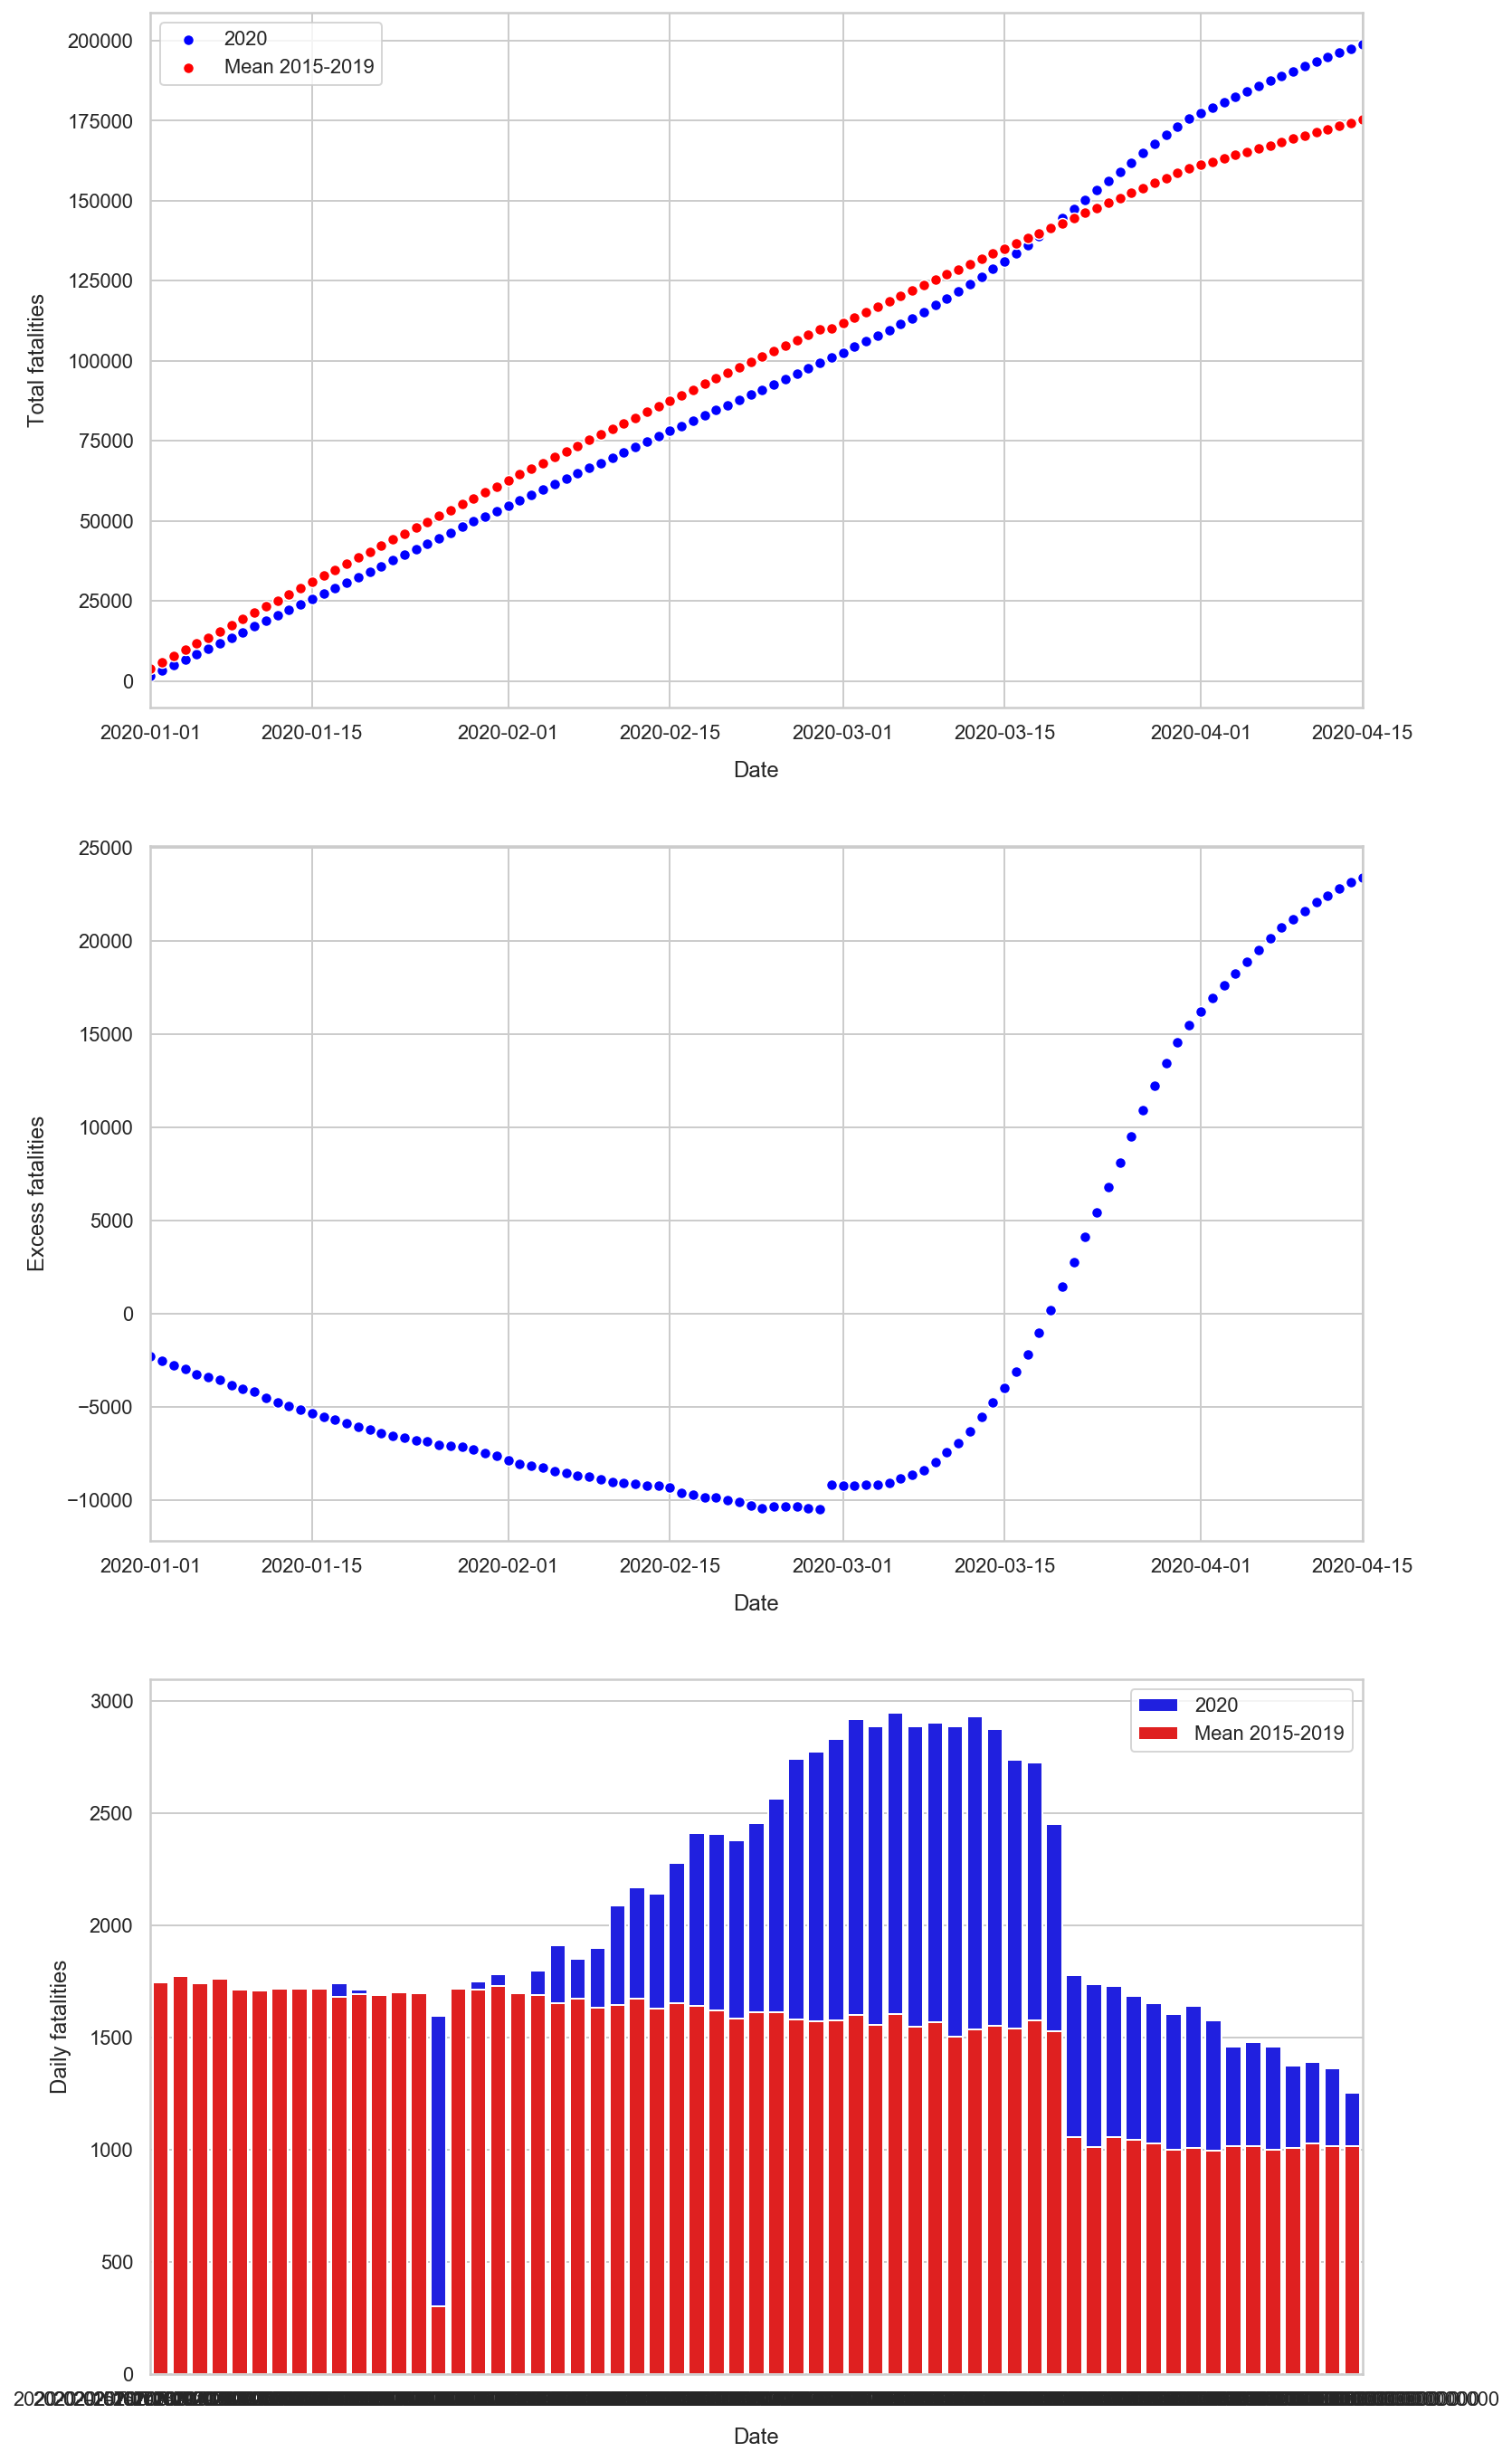

In [27]:
# Total fatalities Italy

# define a grid for subplots
f, axes = plt.subplots(3,1, figsize=(12,24));

# add dates formatted as standard datetime objects
df_fatality_2020 = setDate(data=df_2020, year='2020');

# fatalities grouped by day
df_fatality_2020_daily = df_fatality_2020.groupby('DATE').sum();

# Total fatalities cumulative

# 2020
df_fatality_2020_cumulative = totalDaily(data=df_fatality_2020_daily, col='T_20', new_col='TR_20');
ax = sns.scatterplot(data=df_fatality_2020_cumulative, x=df_fatality_2020_cumulative.index, y='TR_20', color='blue', ax=axes[0]);
ax.set_xlim(df_fatality_2020.DATE.min(),df_fatality_2020.DATE.max());
#x_dates = df_fatality_2020.DATE.dt.strftime('%d-%m')
#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

# mean 2015-2019
df_fatality_mean_cumulative = totalMeanDaily(data=df_fatality_2020_daily, cols=['T_15','T_16','T_17','T_18','T_19'], new_col='TR_MEAN');
ax = sns.scatterplot(data=df_fatality_mean_cumulative, x=df_fatality_mean_cumulative.index, y='TR_MEAN', color='red', ax=axes[0]);
ax.set_xlim(df_fatality_2020.DATE.min(),df_fatality_2020.DATE.max());

axes[0].set_xlabel('Date');
axes[0].set_ylabel('Total fatalities');
ax.legend(['2020','Mean 2015-2019']);

# difference 2020 - mean(2015-2019)
df_fatality_2020_cumulative = df_fatality_2020_cumulative.assign(TR_MEAN = df_fatality_mean_cumulative['TR_MEAN'])
ax = sns.scatterplot(data=df_fatality_2020_cumulative, x=df_fatality_2020_cumulative.index, y=(df_fatality_2020_cumulative.TR_20 - df_fatality_2020_cumulative.TR_MEAN), color='blue', ax=axes[1]);
ax.set_xlim(df_fatality_2020.DATE.min(),df_fatality_2020.DATE.max());

axes[1].set_xlabel('Date');
axes[1].set_ylabel('Excess fatalities');

# Total fatalities per day (limited to period after March 1st)
df_fatality_2020_daily_short = df_fatality_2020_daily[df_fatality_2020_daily.index >= pd.to_datetime('2020-02-15')];

# 2020
ax = sns.barplot(data=df_fatality_2020_daily_short, x=df_fatality_2020_daily_short.index, y='T_20', color='blue', ci=None, estimator=max, ax=axes[2]);
#ax = sns.scatterplot(data=df_fatality_2020_daily_short, x=df_fatality_2020_daily_short.index, y='T_20', color='blue', ax=axes[2]);
#ax.set_xlim(pd.to_datetime('2020-03-01', format='%Y-%m-%d'), df_fatality_2020_daily.index.max());

# mean 2015-2019
cols_TOTALE_15_19 = ['T_15','T_16','T_17','T_18','T_19']
ax = sns.barplot(data=df_fatality_2020_daily_short, x=df_fatality_2020_daily_short.index, y=df_fatality_2020_daily_short[cols_TOTALE_15_19].mean(axis=1), color='red', ci=None, estimator=max, ax=axes[2]);

axes[2].set_xlabel('Date');
axes[2].set_ylabel('Daily fatalities');
ax.legend(['2020','Mean 2015-2019']);

